In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2 as cv2
_ = cv2 # force auto completion
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')


In [ ]:
# only run this cell if you are using Google Colab
import zipfile
from google.colab import drive
from google.colab import files

files.upload()

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
  zip_ref.extractall() # extract to folder "dataset"

Saving brain_tumor_dataset.zip to brain_tumor_dataset.zip


In [ ]:
# Dataset
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-dataset
# run when working locally

import zipfile

z = zipfile.ZipFile('archive.zip')
z.extractall()

In [ ]:
folder = 'dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print('Renamed all files in the yes directory')

Renamed all files in the yes directory


In [ ]:
folder = 'dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print('Renamed all files in the no directory')

Renamed all files in the no directory


### EDA (Exploratary Data Analysis)

In [ ]:
list_yes = os.listdir("dataset/yes/")
number_files_yes = len(list_yes)
print(number_files_yes)

list_no = os.listdir("dataset/no/")
number_files_no = len(list_no)
print(number_files_no)

192
125


Text(0.5, 1.0, 'Count of Brain Tumor Images')

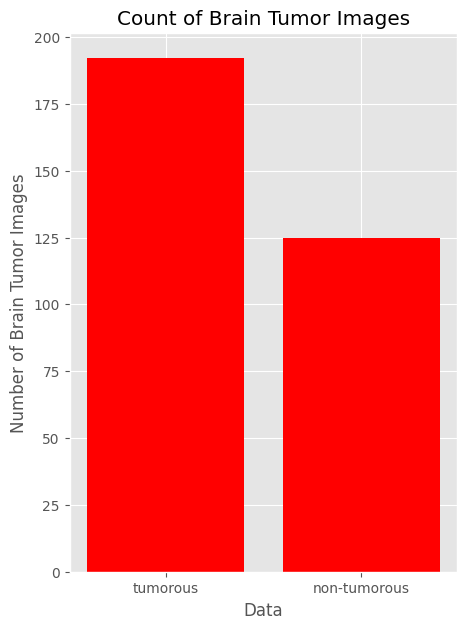

In [ ]:
data = {
    'tumorous': number_files_yes,
    'non-tumorous': number_files_no
}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color='red')

plt.xlabel("Data")
plt.ylabel("Number of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")

## 🧪 Data Augmentation

This section performs **data augmentation** to artificially increase the size and diversity of the dataset. Augmenting the data helps prevent overfitting and improves the model's generalization by exposing it to various transformations of the input images.

### ⚠️ Dataset Imbalance

The original dataset is **imbalanced**, meaning there are significantly more images labeled with brain tumors (`yes`) than without tumors (`no`).  
This imbalance can bias the model toward predicting the majority class. To address this issue, we generate **more augmented images** for the `no` class than for the `yes` class.  
This helps to **balance the dataset** and improve model fairness and performance.

### `augmented_data(...)` Function

The `augmented_data()` function uses Keras' `ImageDataGenerator` to apply random transformations to each image in the input directory:

- `rotation_range=10`: Randomly rotate images up to 10 degrees.
- `width_shift_range=0.1` & `height_shift_range=0.1`: Shift images horizontally or vertically by up to 10%.
- `shear_range=0.1`: Apply shearing transformations.
- `brightness_range=(0.3, 1.0)`: Randomly adjust brightness between 30% and 100%.
- `horizontal_flip=True` & `vertical_flip=True`: Flip images horizontally and vertically.
- `fill_mode='nearest'`: Fill in empty pixels after transformation using the nearest pixel value.

For each image in the folder:
- A number of `n_generated_samples` augmented images are generated.
- The augmented images are saved in `save_to_dir` with a prefix to distinguish them.

### Timing

The `timing()` helper function converts the total elapsed time into a human-readable format (hours:minutes:seconds) to track how long the augmentation process takes.

### Example

```python
augmented_data(file_dir = yes_path, n_generated_samples = 6, save_to_dir = augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples = 9, save_to_dir = augmented_data_path+'no')


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60

    return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3, 1.0),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode = 'nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i += 1
            if i > n_generated_samples:
                break


In [ ]:
if not os.path.isdir('augmented_data'):
    os.mkdir('augmented_data')

if not os.path.isdir('augmented_data/yes'):
    os.mkdir('augmented_data/yes')

if not os.path.isdir('augmented_data/no'):
    os.mkdir('augmented_data/no')

In [ ]:
import time
start_time = time.time()

yes_path = 'dataset/yes/'
no_path = 'dataset/no/'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples = 6, save_to_dir = augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples = 9, save_to_dir = augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time

print(timing(execution_time))

0:1:53.0349235534668


In [ ]:
def data_summmary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = n_pos + n_neg

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of samples: {n}")
    print(f"Positive samples: {pos_per}% | Negative samples: {neg_per}")

In [ ]:
data_summmary(augmented_data_path)

Number of samples: 2592
Positive samples: 51.77469135802469% | Negative samples: 48.22530864197531


In [ ]:
list_yes = os.listdir("augmented_data/yes/")
number_files_yes = len(list_yes)
print(number_files_yes)

list_no = os.listdir("augmented_data/no/")
number_files_no = len(list_no)
print(number_files_no)

1342
1250


Text(0.5, 1.0, 'Count of Brain Tumor Images')

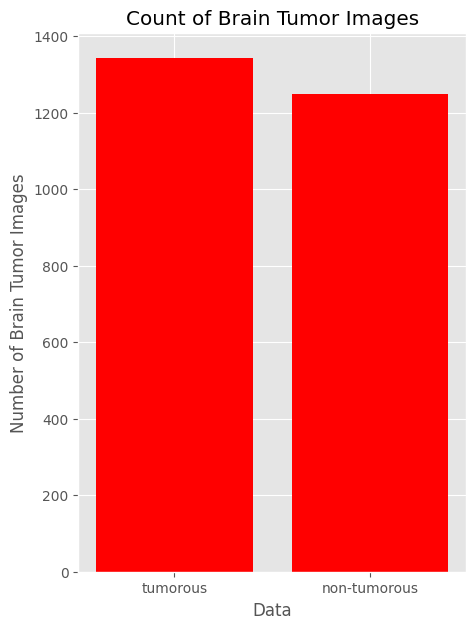

In [ ]:
data = {
    'tumorous': number_files_yes,
    'non-tumorous': number_files_no
}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color='red')

plt.xlabel("Data")
plt.ylabel("Number of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")

## Data Preprocessing

### 🧠 Cropping the Brain Tumor Region from MRI Images

The function `crop_brain_tumor(image, plot=False)` processes an input MRI scan to isolate and crop the area containing the brain. This helps the model focus on the region of interest and ignore irrelevant background.

#### 📷 Step-by-step Breakdown

1. **Convert to Grayscale:**

   ```python
   gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   ```

   * Converting to grayscale simplifies further processing.

2. **Apply Gaussian Blur:**

   ```python
   gray = cv2.GaussianBlur(gray, (5,5), 0)
   ```

   * Reduces noise and smoothens the image, which helps in more accurate thresholding.

3. **Binary Thresholding:**

   ```python
   thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
   ```

   * Converts the image to black and white based on a pixel intensity threshold of 45.

4. **Morphological Operations (Opening):**

   ```python
   thres = cv2.erode(thres, None, iterations=2)
   thres = cv2.dilate(thres, None, iterations=2)
   ```

   * **Erosion** removes small white noises, and **dilation** reconnects disconnected parts of the brain region.

5. **Find the Largest Contour:**

   ```python
   cnts = cv2.findContours(...)
   cnts = imutils.grab_contours(cnts)
   c = max(cnts, key=cv2.contourArea)
   ```

   * Detects all contours and selects the one with the largest area, which is assumed to be the tumor.

6. **Compute the Bounding Box:**

   ```python
   ext_left = tuple(c[c[:,:,0].argmin()][0])
   ext_right = tuple(c[c[:,:,0].argmax()][0])
   ext_top = tuple(c[c[:,:,1].argmin()][0])
   ext_bot = tuple(c[c[:,:,1].argmax()][0])
   ```

   * Finds the extreme points of the contour to define the rectangular region enclosing the tumor.

7. **Crop the Tumor Region:**

   ```python
   new_image = image[ext_top[1]:ext_bot[1], ext_left[0]:ext_right[0]]
   ```

   * Crops the original image based on the bounding box.

8. **Optional Visualization:**

   * If `plot=True`, shows the original and cropped image side-by-side for verification.


In [ ]:
import imutils

def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    ext_left = tuple(c[c[:,:,0].argmin()][0])
    ext_right = tuple(c[c[:,:,0].argmax()][0])
    ext_top = tuple(c[c[:,:,1].argmin()][0])
    ext_bot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[ext_top[1]:ext_bot[1], ext_left[0]:ext_right[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

In [ ]:
img = cv2.imread('augmented_data/no/aug2 no._0_2314.jpg')
crop_brain_tumor(img, True)

In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)

for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [ ]:
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    X = []
    y = []

    image_width, image_height = image_size

    for direcoty in dir_list:
        for filename in os.listdir(direcoty):
            image = cv2.imread(direcoty + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize = (image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if direcoty[-3:] == 'yes':
                y.append(1)
            else:
                y.append(0)
    X = np.array(X)
    y = np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of samples is: {len(X)}")
    print(f"X shape is: {X.shape}")
    print(f"y shape is: {y.shape}")

    return X,y


In [ ]:
augmented_path = 'augmented_data/'
augemented_yes = augmented_path + 'yes'
augemented_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240, 240)

X,y = load_data([augemented_yes, augemented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of samples is: 2592
X shape is: (2592, 240, 240, 3)
y shape is: (2592,)


In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

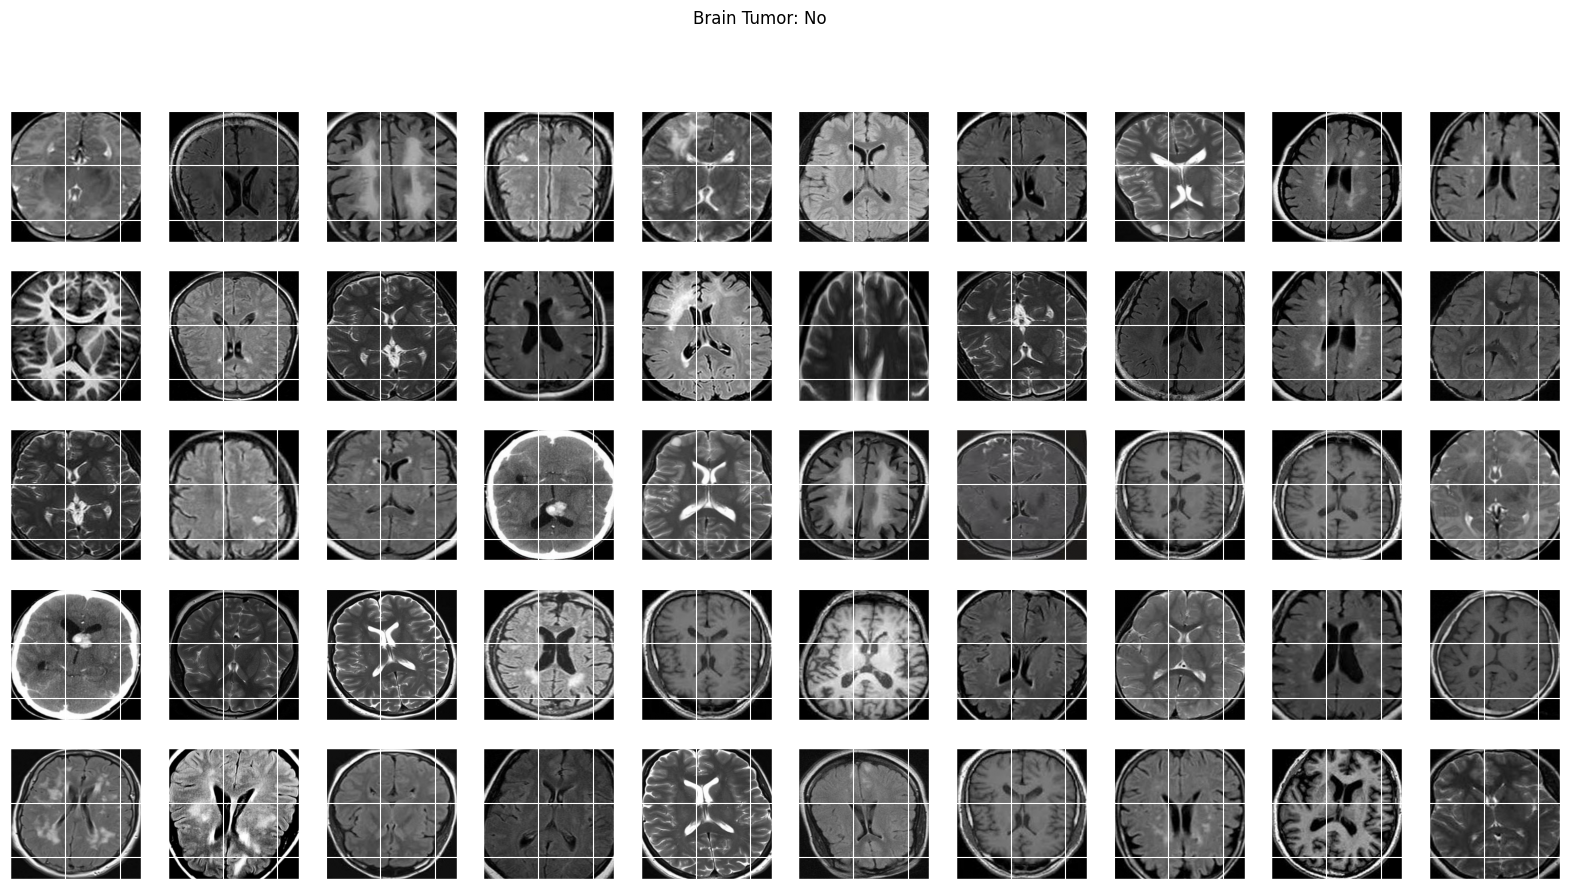

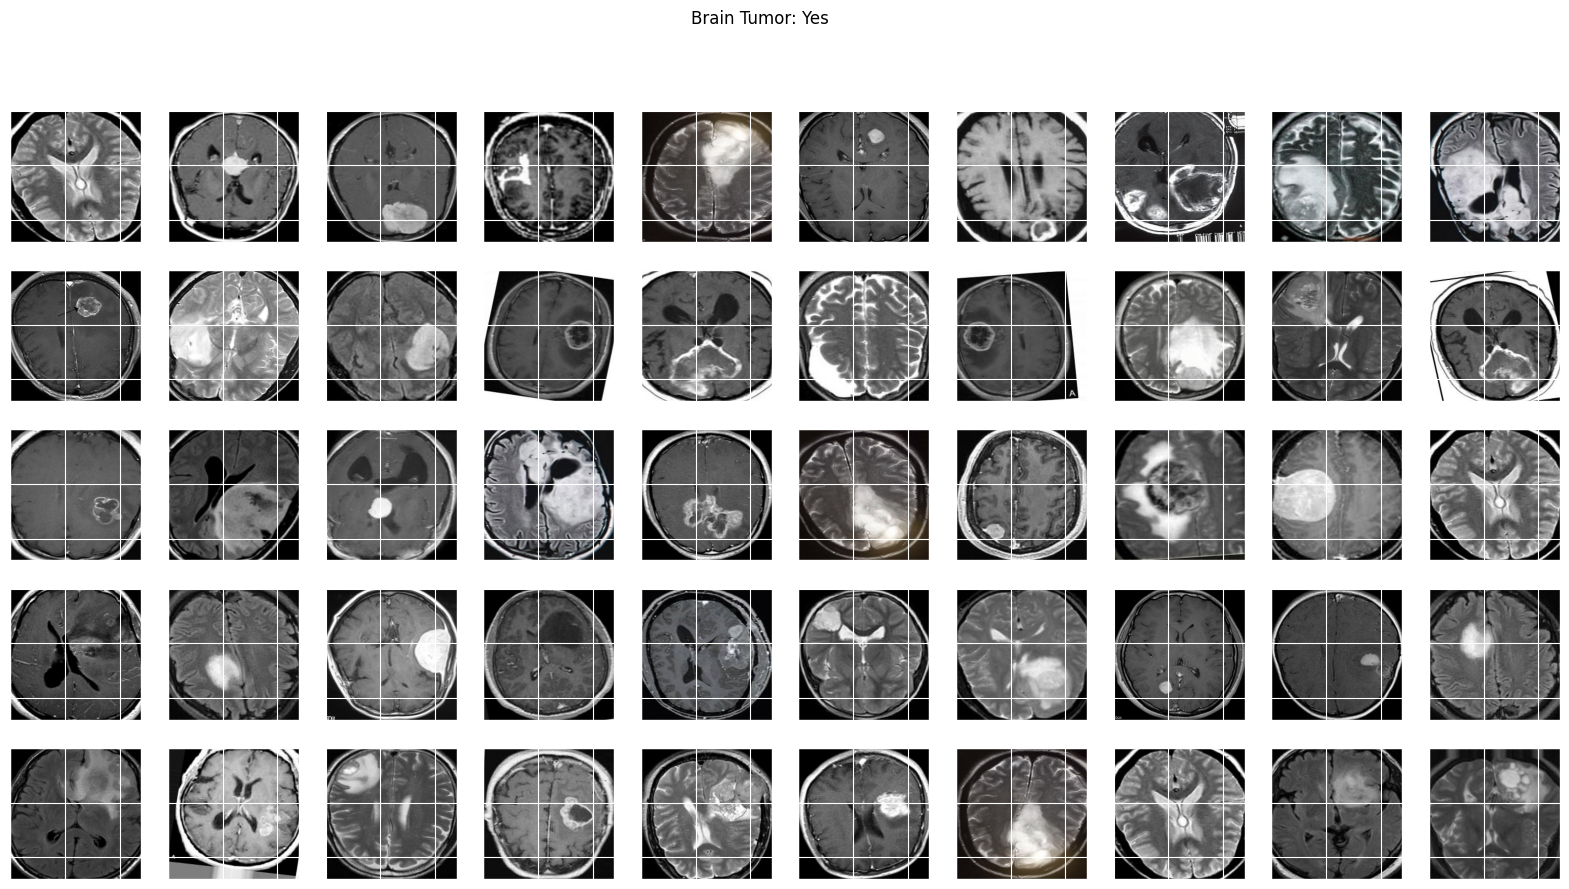

In [ ]:
plot_sample_images(X,y)

### Data Splitting

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)

if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)


In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [ ]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [ ]:
files = os.listdir('augmented_data/yes/')
num_files = len(files)
fnames = []

# 60 20 20 train test valid split
for i in range(0,int(0.6*num_files)):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
num_files = len(files)
fnames = []

# 60 20 20 train test valid split
for i in range(int(0.6*num_files),int(0.8*num_files)):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
num_files = len(files)
fnames = []

# 60 20 20 train test valid split
for i in range(int(0.8*num_files),int(num_files)):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
num_files = len(files)
fnames = []

# 60 20 20 train test valid split
for i in range(0,int(0.6*num_files)):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
num_files = len(files)
fnames = []

# 60 20 20 train test valid split
for i in range(int(0.6*num_files),int(0.8*num_files)):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
num_files = len(files)
fnames = []

# 60 20 20 train test valid split
for i in range(int(0.8*num_files),int(num_files)):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

### Model Building

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip = 0.4,
                                    vertical_flip = 0.4,
                                    rotation_range = 40,
                                    shear_range = 0.2,
                                    width_shift_range = 0.4,
                                    height_shift_range = 0.4,
                                    fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale = 1.0/255)
valid_datagen = ImageDataGenerator(rescale = 1.0/255)


In [ ]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/',
                                                    batch_size=32,
                                                    target_size=(240,240),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

Found 1555 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory('tumorous_and_nontumorous/test/',
                                                  batch_size=32,
                                                  target_size=(240,240),
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                  color_mode='rgb')

Found 518 images belonging to 2 classes.


In [ ]:
valid_generator = valid_datagen.flow_from_directory('tumorous_and_nontumorous/valid/',
                                                    batch_size=32,
                                                    target_size=(240,240),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

Found 519 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
class_name = {value: key for (key, value) in class_labels.items()}

In [ ]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [ ]:
base_model = VGG19(input_shape=(240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss',
                   verbose = 1,
                   mode = 'min',
                   patience=4)

mcp = ModelCheckpoint(filepath,
                      monitor='val_loss',
                      verbose = 1,
                      save_best_only=True,
                      save_weights_only=False,
                      mode='auto',
                      save_freq='epoch')

llr = ReduceLROnPlateau(monitor='val_accuarcy',
                        patience = 3,
                        verbose = 1,
                        factor = 0.5,
                        min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001,
          decay = 1e-6,
          momentum=0.9,
          nesterov=True)

model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
shutil.make_archive("tumorous_and_nontumorous", 'zip', "tumorous_and_nontumorous") # create zip archive for colab upload

'd:\\PYTHON\\BrainTumorDetection\\tumorous_and_nontumorous.zip'

In [ ]:
# better to do training via google colab
#   - upload "dataset" to colab
#   - step through entire notebook
#   - execute training
#   - (download model.h5 file and load it locally to test model)

history_01 = model_01.fit(train_generator,
                          steps_per_epoch=10,
                          epochs=40,
                          callbacks=[es, mcp, llr],
                          validation_data=valid_generator)

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')

In [ ]:
model_01.load_weights('model_weights/vgg19_model_01.h5')
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

In [56]:
import pandas as pd

def plot_accuracy_loss(history, save_path=None, smooth=False, window_size=5):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle("Model Training", fontsize=12)
    max_epoch = len(history.history['accuracy']) + 1
    epochs_list = list(range(1, max_epoch))

    acc = pd.Series(history.history['accuracy'])
    val_acc = pd.Series(history.history['val_accuracy'])
    loss = pd.Series(history.history['loss'])
    val_loss = pd.Series(history.history['val_loss'])

    if smooth:
        acc = acc.rolling(window=window_size, min_periods=1, center=True).mean()
        val_acc = val_acc.rolling(window=window_size, min_periods=1, center=True).mean()
        loss = loss.rolling(window=window_size, min_periods=1, center=True).mean()
        val_loss = val_loss.rolling(window=window_size, min_periods=1, center=True).mean()

    ax1.plot(epochs_list, acc, color='b', label='Training Data')
    ax1.plot(epochs_list, val_acc, color='r', label='Validation Data')
    ax1.set_title('Training Accuracy', fontsize=12)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, loss, color='b', label='Training Data')
    ax2.plot(epochs_list, val_loss, color='r', label='Validation Data')
    ax2.set_title('Training Loss', fontsize=12)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(frameon=False, loc='upper center', ncol=2)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
# next steps:
#   - unfreeze model to increase accuracy (train in colab)

## Incremental unfreezing and finetuning

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
sgd = SGD(learning_rate=0.0001,
          decay = 1e-6,
          momentum=0.9,
          nesterov=True)

model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator,
                          steps_per_epoch=10,
                          epochs=40,
                          callbacks=[es, mcp, llr],
                          validation_data=valid_generator)

In [ ]:
# Unfreeze the entire model
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
#model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = SGD(learning_rate=0.0001,
          decay = 1e-6,
          momentum=0.9,
          nesterov=True)

model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model_03.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=10,
                          epochs=80,
                          callbacks=[es, mcp, llr],
                          validation_data=valid_generator)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_27']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.5125 - loss: 0.7760
Epoch 1: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5122 - loss: 0.7745 - val_accuracy: 0.4990 - val_loss: 0.7171 - learning_rate: 1.0000e-04
Epoch 2/80


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.5498 - loss: 0.7020
Epoch 2: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5475 - loss: 0.7044 - val_accuracy: 0.5665 - val_loss: 0.6703 - learning_rate: 1.0000e-04
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.5578 - loss: 0.6735
Epoch 3: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5583 - loss: 0.6740 - val_accuracy: 0.6917 - val_loss: 0.6271 - learning_rate: 1.0000e-04
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6126 - loss: 0.6887
Epoch 4: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6112 - loss: 0.6886 - val_accuracy: 0.6802 - val_loss: 0.6118 - learning_rate: 1.0000e-04
Epoch 5/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.6399 - loss: 0.6637

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6367 - loss: 0.6635 - val_accuracy: 0.6243 - val_loss: 0.6431 - learning_rate: 1.0000e-04
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.6362 - loss: 0.6278
Epoch 6: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6366 - loss: 0.6269 - val_accuracy: 0.6975 - val_loss: 0.5933 - learning_rate: 1.0000e-04
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6061 - loss: 0.6784
Epoch 7: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6070 - loss: 0.6763 - val_accuracy: 0.6859 - val_loss: 0.5809 - learning_rate: 1.0000e-04
Epoch 8/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6319 - loss: 0.6280
Epoch 8: val_loss did not improve from 0.14425
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6301 - loss: 0.6289 - val_accuracy: 0.6975 - val_loss: 0.5714 - learnin

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8979 - loss: 0.2353 - val_accuracy: 0.9441 - val_loss: 0.1409 - learning_rate: 1.0000e-04
Epoch 41/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9011 - loss: 0.2621
Epoch 41: val_loss did not improve from 0.14088
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9001 - loss: 0.2638 - val_accuracy: 0.9364 - val_loss: 0.1467 - learning_rate: 1.0000e-04
Epoch 42/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8474 - loss: 0.2964
Epoch 42: val_loss did not improve from 0.14088
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8471 - loss: 0.2970 - val_accuracy: 0.8748 - val_loss: 0.2566 - learning_rate: 1.0000e-04
Epoch 43/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9049 - loss: 0.2637
Epoch 43: val_loss did not improve from 0.14088
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9055 - loss: 0.2619 - val_accuracy: 0.9152 - val_loss: 0.1975 - learning_rate: 1.0000e-04
Epoch 44/80
10/10 ━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8831 - loss: 0.2815 - val_accuracy: 0.9480 - val_loss: 0.1343 - learning_rate: 1.0000e-04
Epoch 45/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9196 - loss: 0.2384
Epoch 45: val_loss did not improve from 0.13434
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9197 - loss: 0.2353 - val_accuracy: 0.8459 - val_loss: 0.3064 - learning_rate: 1.0000e-04
Epoch 46/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9291 - loss: 0.2313
Epoch 46: val_loss improved from 0.13434 to 0.10692, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.9282 - loss: 0.2310 - val_accuracy: 0.9595 - val_loss: 0.1069 - learning_rate: 1.0000e-04
Epoch 47/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9448 - loss: 0.1803
Epoch 47: val_loss did not improve from 0.10692
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9436 - loss: 0.1808 - val_accuracy: 0.9538 - val_loss: 0.1255 - learning_rate: 1.0000e-04
Epoch 48/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9189 - loss: 0.2046
Epoch 48: val_loss improved from 0.10692 to 0.10449, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.9172 - loss: 0.2074 - val_accuracy: 0.9576 - val_loss: 0.1045 - learning_rate: 1.0000e-04
Epoch 49/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9047 - loss: 0.2324
Epoch 49: val_loss did not improve from 0.10449
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9054 - loss: 0.2303 - val_accuracy: 0.9634 - val_loss: 0.1096 - learning_rate: 1.0000e-04
Epoch 50/80
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9527 - loss: 0.1511
Epoch 50: val_loss did not improve from 0.10449
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9498 - loss: 0.1556 - val_accuracy: 0.9595 - val_loss: 0.1047 - learning_rate: 1.0000e-04
Epoch 51/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9443 - loss: 0.1457
Epoch 51: val_loss improved from 0.10449 to 0.08766, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9432 - loss: 0.1480 - val_accuracy: 0.9692 - val_loss: 0.0877 - learning_rate: 1.0000e-04
Epoch 52/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9226 - loss: 0.1884
Epoch 52: val_loss did not improve from 0.08766
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9205 - loss: 0.1958 - val_accuracy: 0.9634 - val_loss: 0.0927 - learning_rate: 1.0000e-04
Epoch 53/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9371 - loss: 0.1680
Epoch 53: val_loss did not improve from 0.08766
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9348 - loss: 0.1714 - val_accuracy: 0.9538 - val_loss: 0.1178 - learning_rate: 1.0000e-04
Epoch 54/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9502 - loss: 0.1824
Epoch 54: val_loss did not improve from 0.08766
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9493 - loss: 0.1826 - val_accuracy: 0.9672 - val_loss: 0.0920 - learning_rate: 1.0000e-04
Epoch 55/80
 9/10 ━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9616 - loss: 0.1200 - val_accuracy: 0.9730 - val_loss: 0.0768 - learning_rate: 1.0000e-04
Epoch 56/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9029 - loss: 0.2307
Epoch 56: val_loss did not improve from 0.07685
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9037 - loss: 0.2305 - val_accuracy: 0.9672 - val_loss: 0.0854 - learning_rate: 1.0000e-04
Epoch 57/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9264 - loss: 0.1841
Epoch 57: val_loss did not improve from 0.07685
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9271 - loss: 0.1834 - val_accuracy: 0.9634 - val_loss: 0.0997 - learning_rate: 1.0000e-04
Epoch 58/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9040 - loss: 0.2124
Epoch 58: val_loss did not improve from 0.07685
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9051 - loss: 0.2122 - val_accuracy: 0.9576 - val_loss: 0.0998 - learning_rate: 1.0000e-04
Epoch 59/80
10/10 ━━━━━

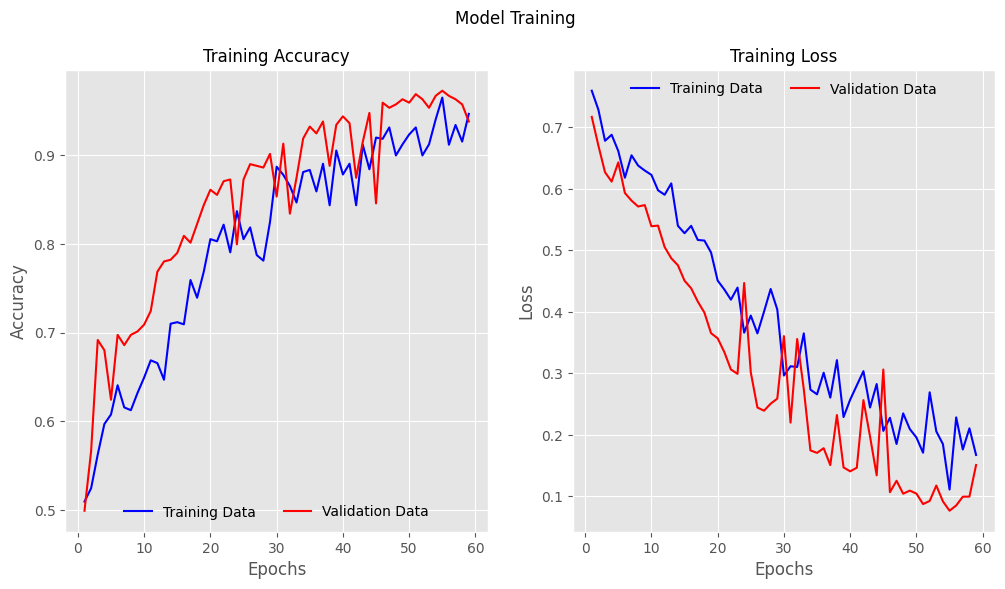

In [57]:
plot_accuracy_loss(history_03)